In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "10_mlops/10b_explain.ipynb"
_nb_title = "Explain predictions"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Explain predictions&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F10_mlops%2F10b_explain.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F10_mlops%2F10b_explain.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/10_mlops/10b_explain.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/10_mlops/10b_explain.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/10_mlops/10b_explain.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Explain predictions

In this notebook, we use Explainable AI to explain why an image classification model makes the predictions that it does.

## Model with preprocess signature

Let's start from the checkpoint created when we trained the model in Chapter 5.
This way, we don't have to retrain the model.

In [1]:
import tensorflow as tf
import os, shutil

MODEL_LOCATION='export/flowers_model3'  # will be created

In [2]:
# load from checkpoint and export a model that has desired signature
CHECK_POINT_DIR='gs://practical-ml-vision-book-data/flowers_5_trained/chkpts'
model = tf.keras.models.load_model(CHECK_POINT_DIR)

In [3]:
IMG_HEIGHT = 345
IMG_WIDTH = 345
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

def preprocess(filename):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

@tf.function(input_signature=[tf.TensorSpec([None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], dtype=tf.float32)])
def xai_model(input_images):
    batch_pred = model(input_images) # same as model.predict()
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
    return {
        'probability': top_prob,
        'flower_type_int': pred_label_index,
        'flower_type_str': pred_label
    }

@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def xai_preprocess(filenames):
    input_images = tf.map_fn(
        preprocess,
        filenames,
        fn_output_signature=tf.float32
    )
    return {
        # match the signature of xai_model
        'input_images': input_images
    }

@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def predict_filename(filenames):
    preproc_output = xai_preprocess(filenames)
    # return xai_model(preproc_output['input_images'])
    return xai_model(**preproc_output)

shutil.rmtree('export', ignore_errors=True)
os.mkdir('export')
model.save(MODEL_LOCATION,
          signatures={
              'serving_default': predict_filename,
              'xai_preprocess': xai_preprocess, # should be exactly what's supplied to model
              'xai_model': xai_model # call the model
          })

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: export/flowers_model3/assets


In [4]:
!saved_model_cli show --dir {MODEL_LOCATION} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['filenames'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_filenames:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['flower_type_int'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: StatefulPartitionedCall:0
    outputs['flower_type_str'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: StatefulPartitionedCall:1
    outputs['probability'] tensor_info:
        d

## Try out the new signatures

In [5]:
serving_fn = tf.keras.models.load_model(MODEL_LOCATION).signatures['serving_default']
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)

{'flower_type_int': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 0, 4, 4])>, 'probability': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.39833778, 0.9999609 , 0.9947188 , 0.95900667, 0.94177294],
      dtype=float32)>, 'flower_type_str': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'dandelion', b'dandelion', b'daisy', b'tulips', b'tulips'],
      dtype=object)>}


In [6]:
serving_fn = tf.keras.models.load_model(MODEL_LOCATION).signatures['xai_preprocess']
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)

{'input_images': <tf.Tensor: shape=(1, 345, 345, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0.

## Create explanation metadata

We can use a Python API to create explanations.json or we can hand-create it.

As a baseline, we'll use a random image (we could also use all zeros or all ones)

In [8]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
import numpy as np

np.random.seed(42)

export_path=MODEL_LOCATION  # save with model
# We want to explain 'xai_model' signature.
builder = SavedModelMetadataBuilder(
    export_path,
    signature_name='xai_model',
    outputs_to_explain=['probability'])
random_baseline = np.random.rand(IMG_HEIGHT, IMG_WIDTH, 3)
builder.set_image_metadata(
    'input_images',
    input_baselines=[random_baseline.tolist()])
builder.save_metadata(export_path)

In [9]:
!head -20 {MODEL_LOCATION}/explanation_metadata.json

{
  "outputs": {
    "probability": {
      "output_tensor_name": "probability"
    }
  },
  "inputs": {
    "input_images": {
      "input_tensor_name": "input_images",
      "encoding": "identity",
      "modality": "image",
      "input_baselines": [
        [
          [
            [
              0.3745401188473625,
              0.9507143064099162,
              0.7319939418114051
            ],
            [


## Deploy explanation model to Cloud AI Platform

Deploy the model above to AI Platform, to get integrated gradients explanations.

In [ ]:
%%writefile caip_deploy_regional.sh
#!/bin/bash

MODEL_NAME=flowers_regional
MODEL_LOCATION="gs://practical-ml-vision-book-data/flowers_5_trained" # will change when we call script
VERSION_NAME=ig
EXPLAIN="--explanation-method integrated-gradients --num-integral-steps 25"
REGION='us-central1'  # CHANGE! You need GPU quota in this region
BUCKET='ai-analytics-solutions-kfpdemo' # CHANGE! for staging


while [[ "$#" -gt 0 ]]; do
    case $1 in
        -v|--version) VERSION_NAME="$2"; shift ;;
        -m|--model_location) MODEL_LOCATION="$2"; shift ;;
        *) echo "Unknown parameter passed: $1"; exit 1 ;;
    esac
    shift
done

if [[ "$VERSION_NAME" -eq "xrai" ]]; then
   EXPLAIN="--explanation-method xrai --num-integral-steps 25"
fi

echo "Deploying $MODEL_NAME:$VERSION_NAME with $EXPLAIN from $MODEL_LOCATION"

if [[ $(gcloud ai-platform models list --region=$REGION --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "The model named $MODEL_NAME already exists."
else
    # create model
    echo "Creating $MODEL_NAME model now."
    gcloud ai-platform models create --region=$REGION --enable-logging $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --region=$REGION --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already the existing model $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --quiet --region=$REGION --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this script again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME $EXPLAIN"
gcloud beta ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --region=$REGION  --machine-type n1-standard-4 \
       --framework=tensorflow --python-version=3.7 --runtime-version=2.1 \
       --origin=$MODEL_LOCATION --staging-bucket=gs://$BUCKET $EXPLAIN

In [18]:
!bash ./caip_deploy_regional.sh --model_location {MODEL_LOCATION}

Deploying flowers_regional:ig21 from export/flowers_model3
Using endpoint [https://us-central1-ml.googleapis.com/]
The model named flowers_regional already exists.
Using endpoint [https://us-central1-ml.googleapis.com/]
Creating flowers_regional:ig21 --explanation-method integrated-gradients --num-integral-steps 25
Using endpoint [https://us-central1-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.


Wait until the model has finished deploying. You can check the status by going to https://console.cloud.google.com/ai-platform/models

In [14]:
%%writefile request.json
{
    "instances": [
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg"
        }
    ]
}

Overwriting request.json


In [22]:
!gcloud ai-platform predict --region=us-central1 --model=flowers_regional --version=ig --json-request=request.json

Using endpoint [https://us-central1-ml.googleapis.com/]
FLOWER_TYPE_INT  FLOWER_TYPE_STR  PROBABILITY
1                dandelion        0.398337
1                dandelion        0.999961
0                daisy            0.994719
4                tulips           0.959007
4                tulips           0.941772


## Getting Integrated Gradient Explanations

In [30]:
!gcloud beta ai-platform explain --region=us-central1 --model=flowers_regional --version=ig --json-request=request.json > response.json

Using endpoint [https://us-central1-ml.googleapis.com/]


In [45]:
import json
import base64
input_images = []
with open('request.json') as ifp:
    instances = json.load(ifp)['instances']
    for instance in instances:
        img_bytes = tf.io.read_file(instance['filenames'])
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
        input_images.append(img.numpy())
        
explain_images = []
with open('response.json') as ifp:
    explanations = json.load(ifp)['explanations']
    for expln in explanations:
        b64bytes = expln['attributions_by_label'][0]['attributions']['input_images']['b64_jpeg']
        img_bytes = base64.b64decode(b64bytes)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        explain_images.append(img.numpy())
        print("approx error = {}".format(expln['attributions_by_label'][0]['approx_error']))

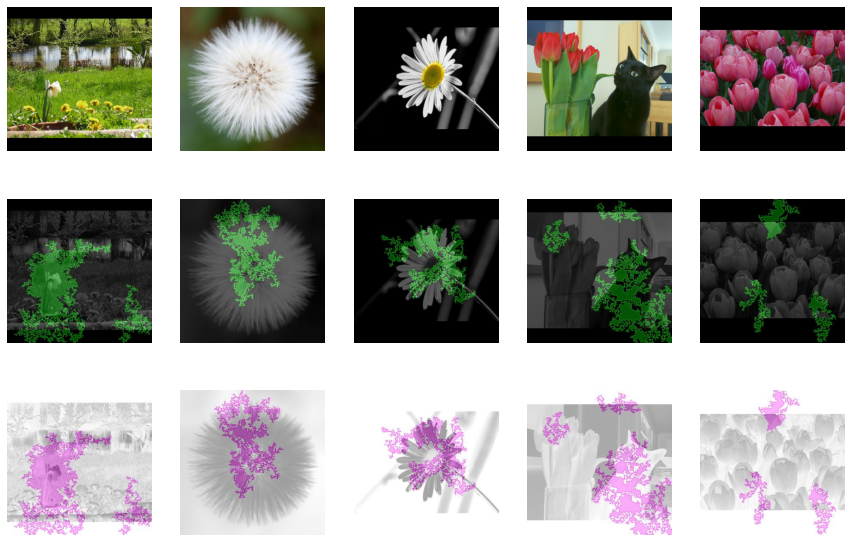

In [81]:
import matplotlib.pyplot as plt
import tensorflow as tf

f, ax = plt.subplots(3, 5, figsize=(15,10))
for idx in range(len(input_images)):
    ax[0, idx].imshow(input_images[idx])
    ax[1, idx].imshow(explain_images[idx])
    ax[2, idx].imshow(1-explain_images[idx])
    ax[0, idx].axis('off')
    ax[1, idx].axis('off')
    ax[2, idx].axis('off')

## Deploying model and getting XRAI explanations

The technique is the same as for IG. Just specify xrai as the method.

In [86]:
!bash ./caip_deploy_regional.sh --model_location {MODEL_LOCATION} --version xrai

Deploying flowers_regional:xrai with --explanation-method xrai --num-integral-steps 25 from export/flowers_model3
Using endpoint [https://us-central1-ml.googleapis.com/]
The model named flowers_regional already exists.
Using endpoint [https://us-central1-ml.googleapis.com/]
Creating flowers_regional:xrai --explanation-method xrai --num-integral-steps 25
Using endpoint [https://us-central1-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.


Wait until the model has finished deploying. You can check the status by going to https://console.cloud.google.com/ai-platform/models

In [88]:
!gcloud beta ai-platform explain --region=us-central1 --model=flowers_regional --version=xrai --json-request=request.json > response.json

Using endpoint [https://us-central1-ml.googleapis.com/]


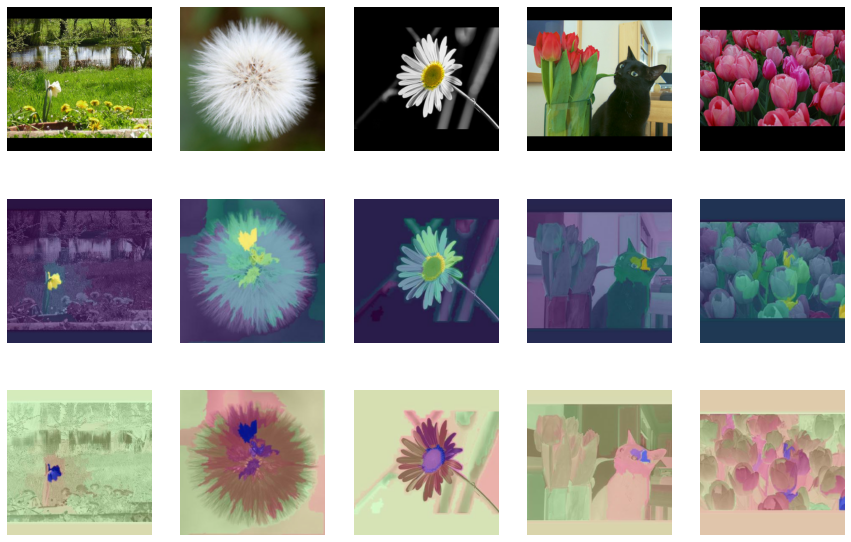

In [89]:
import json
import base64
import matplotlib.pyplot as plt
import tensorflow as tf

input_images = []
with open('request.json') as ifp:
    instances = json.load(ifp)['instances']
    for instance in instances:
        img_bytes = tf.io.read_file(instance['filenames'])
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
        input_images.append(img.numpy())
        
explain_images = []
with open('response.json') as ifp:
    explanations = json.load(ifp)['explanations']
    for expln in explanations:
        b64bytes = expln['attributions_by_label'][0]['attributions']['input_images']['b64_jpeg']
        img_bytes = base64.b64decode(b64bytes)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        explain_images.append(img.numpy())
        print("approx error = {}".format(expln['attributions_by_label'][0]['approx_error']))

f, ax = plt.subplots(3, 5, figsize=(15,10))
for idx in range(len(input_images)):
    ax[0, idx].imshow(input_images[idx])
    ax[1, idx].imshow(explain_images[idx])
    ax[2, idx].imshow(1-explain_images[idx])
    ax[0, idx].axis('off')
    ax[1, idx].axis('off')
    ax[2, idx].axis('off')

The resulting explanations are much, much better.

For the first flower image, the model focuses on the tall white flower and only that flower. It is clear that the model has learned to ignore the smaller flowers in the background. Even though IG seemed to indicate that the background was important, it is clear from xRAI that the model discards that information in favor of the most prominent flower in the image. In the second image, the yellow-ish center and white petals are what the model keys off on (IG got this right also). The precision of the xRAI approach is clear for the third image – the method picks up on the narrow band of bright yellow where the petals join the center. That is unique to daisies, and helps distinguish them from similarly colored dandelions. In the fourth image, the tulip bulbs are what the model uses, although the cat confuses its attention. 

For images like X-rays, Integrated Gradients might do better.

## Extras

<pre>

## This should work, but regional endpoint not understood. Filed https://b.corp.google.com/issues/178844065

import explainable_ai_sdk

PROJECT_ID=!gcloud config get-value project
print(PROJECT_ID)
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID[0], 'flowers', 'ig')
instances = [
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg"
        },
        {
            "filenames": "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg"
        }
]
ig_response = remote_ig_model.explain(instances)
for response in ig_response:
    response.visualize_attributions()
    
</pre>

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.